In [2]:
%pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.5 MB/s eta 0:00:00


In [6]:



from io import BytesIO
from datetime import datetime


import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision import transforms
from torchvision import transforms as T


import cv2
from PIL import Image

import boto3
from botocore.config import Config

import io






AWS_ACCESS_KEY_ID=""
AWS_SECRET_ACCESS_KEY=""
S3_BUCKET=""
SAMPLE_RESPONSE='{"url": "", "inference": [  {"class_id": 0, "class_name": "Clase 0", "count": 15, "avg_confidence": 2.03},  {"class_id": 2, "class_name": "Clase 2", "count": 107, "avg_confidence": 5.34},  {"class_id": 4, "class_name": "Clase 4", "count": 29, "avg_confidence": 4.13},  {"class_id": 5, "class_name": "Clase 5", "count": 9, "avg_confidence": 1.88}]}'



In [20]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_image_with_boxes(image, prediction, threshold=0.5):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')

    scores = prediction[0]['scores'].cpu().numpy()
    keep = scores > threshold

    keepPredictions = prediction[0]['boxes'].cpu().numpy()[keep]
    # print("keepPredictions: " + str(len(keepPredictions)))

    print(keepPredictions, scores)

    for box in prediction[0]['boxes'].cpu().numpy()[keep]:
        print("box")
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            color='blue',
            linewidth=2
        )
        ax.add_patch(rect)

    # plt.tight_layout()


    plt.tight_layout()

    # Save to buffer instead of showing
    buf = BytesIO()
    fig.savefig(buf, format='jpeg', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    plt.close(fig)  # <-- Close the original figure to avoid duplicate display

    # Load image from buffer
    image = Image.open(buf).copy()
    buf.close()

    # Convert to NumPy array
    image_array = np.array(image)

    # Plot the image
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off')
    plt.title(str(len(keepPredictions)) + " predicciones")
    plt.show()

    return image_array, len(keepPredictions)


def get_model_object_detection(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def plot_predictions_test(model, pil_image, threshold=0.5):

  transform = T.Compose([
      T.ToTensor(),
  ])

  image = transform(pil_image)

  model.eval()

  img_tensor = image.unsqueeze(0).to(DEVICE)

  with torch.no_grad():
      prediction = model(img_tensor)

  image = F.to_pil_image(image)

  image_array, pred_count = get_image_with_boxes(image, prediction, threshold)

  return image_array, pred_count



def predictImageMask(img):


    NUM_CLASSES = 6


    model1 = get_model_object_detection(NUM_CLASSES)

    #======================================================================
    # PTH del modelo preentrenado
    # https://drive.google.com/file/d/1b4aAcYpbdFQRbQxl3QDrjoai7ET6JMXH/view?usp=sharing
    #=======================================================================

    model1.load_state_dict(torch.load('aerial_animals_fasterrcnn.pth'))

    model1.to(DEVICE)

    model1.eval()

    img_pred2, pred_count = plot_predictions_test(model1, img)

    image_url = '' # upload_image_to_s3(img_pred2)

    json_result = {
        "url": image_url,
        "inferences": [
            {
               'class_id': 0,
               'class_name': 'Clase 0',
               'count': pred_count,
               'avg_confidence': 1.0
            }
        ]
    }
    return json_result

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[4865.7036 3121.4202 4917.894  3184.4084]] [0.56865036 0.36452416 0.2615926  0.22729145 0.22469684 0.17381038
 0.1553494  0.14593111 0.12803477 0.12368319 0.12172345 0.11689887
 0.11660582 0.11438073 0.10893284 0.10666589 0.10277887 0.10264841
 0.10199834 0.09664714 0.0796938  0.07900587 0.07846939 0.07807994
 0.07749368 0.07729804 0.07493404 0.07491615 0.07014325 0.06876487
 0.06683312 0.06648286 0.06571893 0.06317686 0.06065652 0.06060074
 0.05949573 0.05745712 0.05626448 0.05581456 0.05551612 0.05291669
 0.05205281]
box


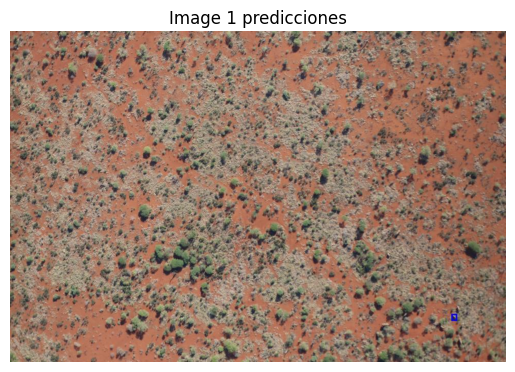

{'url': '',
 'inferences': [{'class_id': 0,
   'class_name': 'Clase 0',
   'count': 1,
   'avg_confidence': 1.0}]}

In [21]:
from PIL import Image

image_path = "052dd6b36a90b1d68fc38a6151b43caf7cbc9d43.JPG"

pil_image = Image.open(image_path).convert("RGB")

json_result = predictImageMask(pil_image)

json_result